In [1]:
using Compat, Random, Distributions, LinearAlgebra, Statistics, SpecialFunctions, CSV, LaTeXStrings, Plots, Interpolations

gr(fmt=:png)
e = 2.7182818284
Random.seed!(1);

In [2]:
function gamma_pdf(x, param)
    a = param[1]
    b = param[2]
    return b^a/gamma(a)*x^(a-1)*exp(-b*x)
end

gamma_pdf (generic function with 1 method)

In [3]:
a2 = 4.782
Na = 365/32.054;
V = 0.26^2;
X = 5;
delta = 1e-5;
x = collect(0:delta:X);
Size = length(x);
L = zeros(Size);
q = zeros(Size);
Q = zeros(Size);
Integral = zeros(Size);

In [4]:
# discretize the Gamma distribution

Q[1] = 1/2
q[1] = 0
bet = sqrt(a2*(a2+1)/V)

for i in 2:1:Size
    q[i] = gamma_pdf(x[i], [a2, bet])/2
    Q[i] = Q[i-1] + delta*(q[i]+q[i-1])/2
end

# approximate the intergral of 1-CDF to find Lambda

Integral[end] = q[end]/bet^2
for i in 2:1:Size
    Integral[Size-i+1] = Integral[Size-i+2] + delta*(1-Q[Size-i+1]/2-Q[Size-i+2]/2)
end

# find he generalized hazard function
L = Na*V*q./Integral/2


# the integral is poorly approximated at infinity, so use equation (20) to fit a 5-th degree polynomial at the tail
# the resulting hazard is twice differentiable everywhere

appr = Na*V/2*((a2-2)*(a2-1)*(x.^(-2)) - 2*bet*(a2-1)*(x.^(-1)) + (x./x)*bet^2)
left = Int64(round(1.3/x[end]*length(x)))
right = Int64(round(3/x[end]*length(x)))

matr = [[x[left]^5 x[left]^4 x[left]^3 x[left]^2 x[left] 1]; [x[right]^5 x[right]^4 x[right]^3 x[right]^2 x[right] 1]; 
        [5*x[left]^4 4*x[left]^3 3*x[left]^2 2*x[left] 1 0]; [5*x[right]^4 4*x[right]^3 3*x[right]^2 2*x[right] 1 0]
        [20*x[left]^3 12*x[left]^2 6*x[left] 2 0 0]; [20*x[right]^3 12*x[right]^2 6*x[right] 2 0 0]]
vect = [L[left]; appr[right]; (L[left]-L[left-1])/delta; (appr[right+1]-appr[right])/delta; (L[left]-2*L[left-1]+L[left-2])/delta^2; (appr[right]-2*appr[right+1]+appr[right+2])/delta^2]
coef = matr \ vect
fr = [L[1:left]; coef[1]*x[left+1:right-1].^5 + coef[2]*x[left+1:right-1].^4 + coef[3]*x[left+1:right-1].^3 + coef[4]*x[left+1:right-1].^2 + coef[5]*x[left+1:right-1] + coef[6]*ones(right-left-1); appr[right:end]];

In [5]:
# make the grid

smallSize = 10000
smallDelta = X/(smallSize-1)
x_small = collect(0:smallDelta:X);
fr_itp = LinearInterpolation(x,fr)
interpolated_fr = fr_itp(x_small);

In [6]:
# fill matrices for the discretized ODE

r = 0.02
s = Na*V/2
B = 1

A = zeros(smallSize,smallSize);
A[1,1] = 1
A[2,1] = -smallDelta^(-2)*s
A[2,2] = 2*smallDelta^(-2)*s + r + interpolated_fr[2]
A[2,3] = -smallDelta^(-2)*s
A[smallSize-1,smallSize-2] = -smallDelta^(-2)*s
A[smallSize-1,smallSize-1] = 2*smallDelta^(-2)*s + r + interpolated_fr[end-1]
A[smallSize-1,smallSize] = -smallDelta^(-2)*s
for i in 3:1:smallSize-2
    A[i,i-2] = smallDelta^(-2)/14*s
    A[i,i-1] = -16*smallDelta^(-2)/14*s
    A[i,i] = 30*smallDelta^(-2)/14*s + r + interpolated_fr[i]
    A[i,i+1] = -16*smallDelta^(-2)/14*s
    A[i,i+2] = smallDelta^(-2)/14*s
end
A[smallSize,smallSize] = r + interpolated_fr[end]
D = 2*B*x_small;

In [7]:
# solve the linear system
u = A \ D;

In [8]:
# fill the value function and the distribution of menu cost

U = []
L_prime = []
G = []
append!(U,0)
append!(L_prime,0)
append!(G,0)
for i in 2:1:smallSize
    append!(U,U[i-1]+smallDelta*(u[i]+u[i-1])/2)
    append!(L_prime,(interpolated_fr[i]-interpolated_fr[i-1])/smallDelta)
    append!(G,G[i-1]+(U[i]-U[i-1])*L_prime[i-1]/u[i]/(Na*a2*(a2+1)/2))
end

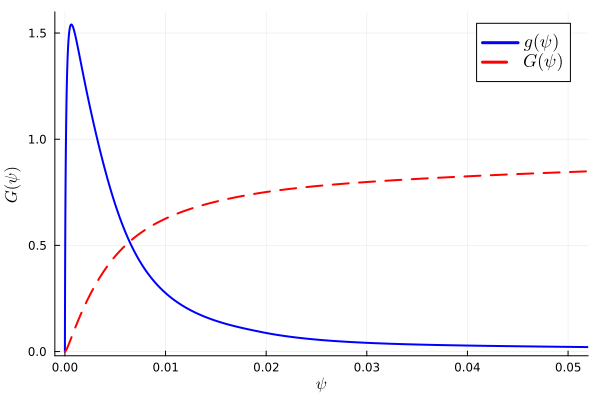

In [9]:
# plot the distribution of menu cost

g = L_prime[1:end-1]./u[1:end-1]/(Na*a2*(a2+1)/2)/80
Plots.plot(U[1:end-1],g,lw=2,legendfontsize=12,color=:blue,label=L"g(\psi)",ylim=[-0.02,1.6],xlim=[-0.001,0.052])
Plots.plot!(U[1:end-1],G[1:end-1],lw=2,ls=:dash,color=:red,label=L"G(\psi)",ylabel=L"G(\psi)",xlabel=L"\psi",legend=:topright)

In [10]:
# print the mode, the mean, and the median

U[argmax(g)], sum(U[1:end-1].*g)/sum(g), U[findfirst(z->G[z]>1/2,1:length(G))]

(0.0006398820843010197, 0.007862140846129035, 0.006022292891062917)

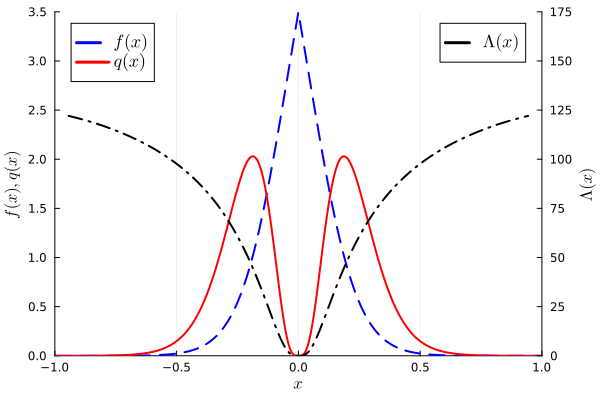

In [11]:
# plot the invariant distribution, the distribution of price changes, and the generalized hazard function

x_twosided = [-reverse(x[2:150000]); x[1:150000]]
q_twosided = [reverse(q[2:150000]); q[1:150000]]
Q_twosided = [ones(150000-1)-reverse(Q[2:150000]); Q[1:150000]]
fr_twosided = [reverse(fr[2:150000]); fr[1:150000]]
Integral_twosided = [reverse(Integral[2:150000]); Integral[1:150000]]
Plots.plot(x_twosided,Integral_twosided*2/V,lw=2,legendfontsize=12,ls=:dash,xlimits=[-1.0,1.0],ylimits=[0,3.5],color=:blue,xlabel=L"x",legend=:topleft,label=L"f(x)",ylabel=L"f(x),q(x)")
Plots.plot!(x_twosided,q_twosided,lw=2,color=:red,xlabel=L"x",label=L"q(x)")
Plots.plot!(twinx(),fr_twosided,lw=2,color=:black,legendfontsize=12,ls=:dashdot,ylimits=[-0,175],ylabel=L"\Lambda(x)",xticks=false,label=L"\Lambda(x)",grid=false)